# **PENDAHULUAN**
- **Proyek**: Membangun model klasifikasi untuk deteksi tingkat depresi, kecemasan, dan stres.
- **Framework**: TensorFlow/Keras.
- **Data**: Berdasarkan kuisioner dengan indikator dari skala yang ditentukan.

# **Import Library**
- Pandas, NumPy: Untuk manipulasi data.
- Matplotlib, Seaborn: Untuk visualisasi.
- TensorFlow/Keras: Untuk pembuatan dan pelatihan model.
- Scikit-learn: Untuk preprocessing dan evaluasi tambahan.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer

# **Load Dataset**

In [ ]:
def load_dataset_from_url():
    url = 'https://raw.githubusercontent.com/KEPSTON1/CAPSTONE-SPIRIT/main/dataset.csv'
    local_file = "dataset.csv"
    try:
        if not os.path.exists(local_file):
            print("Downloading dataset...")
            data = pd.read_csv(url)
            data.to_csv(local_file, index=False)
            print("Dataset downloaded and cached locally.")
        else:
            print("Loading dataset from local cache...")
            data = pd.read_csv(local_file)
        print(f"\nDataset Loaded Successfully! Shape: {data.shape}")
        return data
    except Exception as e:
        print(f"Failed to load dataset. Error: {e}")
        return None

data = load_dataset_from_url()

if data is None:
    raise ValueError("Dataset could not be loaded. Check the URL or file path.")

Dataset downloaded and cached locally.

Dataset Loaded Successfully! Shape: (586, 48)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

def normalize_data(data):
    """
    Normalisasi data menggunakan MinMaxScaler untuk setiap kolom numerik
    """
    scaler = MinMaxScaler()
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

    print("\n--- Data setelah normalisasi ---")
    print(data.head())
    return data

if data is not None:
    data = normalize_data(data)


--- Data setelah normalisasi ---
             Timestamp               Email Address  \
0  11/11/2024 20:01:37   igustisuryaadwn@gmail.com   
1  11/11/2024 20:02:31      fredyaryanta@gmail.com   
2  11/11/2024 20:07:00    pandddeputra12@gmail.com   
3  11/11/2024 20:08:41         adihazel8@gmail.com   
4  11/11/2024 20:11:10  niputuadelia0303@gmail.com   

                              Nama  Usia (Contoh: 18) Jenis Kelamin  \
0  I Gusti Agung Surya Adhiwinata            0.204545     Laki-Laki   
1           I Nyoman Fredy Aryanta           0.863636     Laki-Laki   
2         I Putu Pande Surya Putra           0.204545     Laki-Laki   
3          I Made Adi Hazel Nagata           0.136364     Laki-Laki   
4      Ni Putu Adelia Candra Swari           0.227273     Perempuan   

  Status Pekerjaan  \
0          Pelajar   
1          Bekerja   
2          Pelajar   
3          Pelajar   
4          Pelajar   

  Saya menyatakan bersedia secara sukarela untuk berpartisipasi pada penelitian i

In [ ]:
# Calculate Scores and Categories
def calculate_scores_and_categories(data):
    """
    Hitung skor total untuk Depresi, Kecemasan, dan Stres
    dan kategorikan sesuai indikator penilaian.
    """
    depresi_cols = [3, 5, 10, 13, 16, 17, 21, 24, 26, 31, 34, 37, 38, 42]
    kecemasan_cols = [2, 4, 7, 9, 15, 19, 20, 23, 25, 28, 30, 36, 40, 41]
    stres_cols = [1, 6, 8, 11, 12, 14, 18, 22, 27, 29, 32, 33, 35, 39]

    depresi_cols = [col - 1 for col in depresi_cols]
    kecemasan_cols = [col - 1 for col in kecemasan_cols]
    stres_cols = [col - 1 for col in stres_cols]

    for col in depresi_cols + kecemasan_cols + stres_cols:
        data.iloc[:, col] = pd.to_numeric(data.iloc[:, col], errors='coerce').fillna(0)

    data['Skor_Depresi'] = data.iloc[:, depresi_cols].sum(axis=1)
    data['Skor_Kecemasan'] = data.iloc[:, kecemasan_cols].sum(axis=1)
    data['Skor_Stres'] = data.iloc[:, stres_cols].sum(axis=1)

    def categorize(skor, thresholds):
        for i, threshold in enumerate(thresholds):
            if skor <= threshold:
                return i
        return len(thresholds)

    depresi_thresholds = [9, 13, 20, 27]
    kecemasan_thresholds = [7, 9, 14, 19]
    stres_thresholds = [14, 18, 25, 33]

    data['Kategori_Depresi'] = data['Skor_Depresi'].apply(lambda x: categorize(x, depresi_thresholds))
    data['Kategori_Kecemasan'] = data['Skor_Kecemasan'].apply(lambda x: categorize(x, kecemasan_thresholds))
    data['Kategori_Stres'] = data['Skor_Stres'].apply(lambda x: categorize(x, stres_thresholds))

    # Menampilkan output
    print("\n--- Skor dan Kategori Depresi, Kecemasan, dan Stres ---")
    print(data[['Skor_Depresi', 'Kategori_Depresi', 'Skor_Kecemasan', 'Kategori_Kecemasan', 'Skor_Stres', 'Kategori_Stres']].head())

    return data

if data is not None:
    data = calculate_scores_and_categories(data)



--- Skor dan Kategori Depresi, Kecemasan, dan Stres ---
  Skor_Depresi  Kategori_Depresi Skor_Kecemasan  Kategori_Kecemasan  \
0     4.333333                 0       2.537879                   0   
1          2.0                 0        3.19697                   0   
2     3.333333                 0       3.204545                   0   
3          2.0                 0       2.136364                   0   
4     3.333333                 0       4.560606                   0   

  Skor_Stres  Kategori_Stres  
0   2.666667               0  
1        3.0               0  
2        2.0               0  
3   1.666667               0  
4   2.333333               0  


In [ ]:
print(data.columns)

Index(['Timestamp', 'Email Address', 'Nama', 'Usia (Contoh: 18)',
       'Jenis Kelamin', 'Status Pekerjaan',
       'Saya menyatakan bersedia secara sukarela untuk berpartisipasi pada penelitian ini dengan mengisi kuesioner selama kurang lebih 20-30 menit tanpa paksaan dari pihak manapun. Saya sepenuhnya memahami apa yang telah disampaikan serta apa yang diharapkan dari saya selaku partisipan penelitian. Saya berhak untuk berhenti mengisi kuesioner ini kapan saja tanpa perlu memberikan penjelasan. Saya memberikan izin untuk menggunakan data yang saya berikan hanya untuk kepentingan penelitian ini. Saya telah memahami bahwa informasi yang diperoleh dari penelitian ini sepenuhnya rahasia dan hanya digunakan untuk kepentingan ilmiah',
       'Menjadi marah karena hal-hal kecil/sepele', 'Mulut terasa kering',
       'Tidak dapat melihat hal yang positif dari suatu\nkejadian',
       'Merasakan gangguan dalam bernapas (napas cepat,\nsulit bernapas)',
       'Merasa sepertinya tidak kuat la

# **Preprocessing Data & Labeling**


--- Preprocessing Data ---

--- Checking Missing Values ---
No missing values found.

--- Visualizing Feature Distributions ---


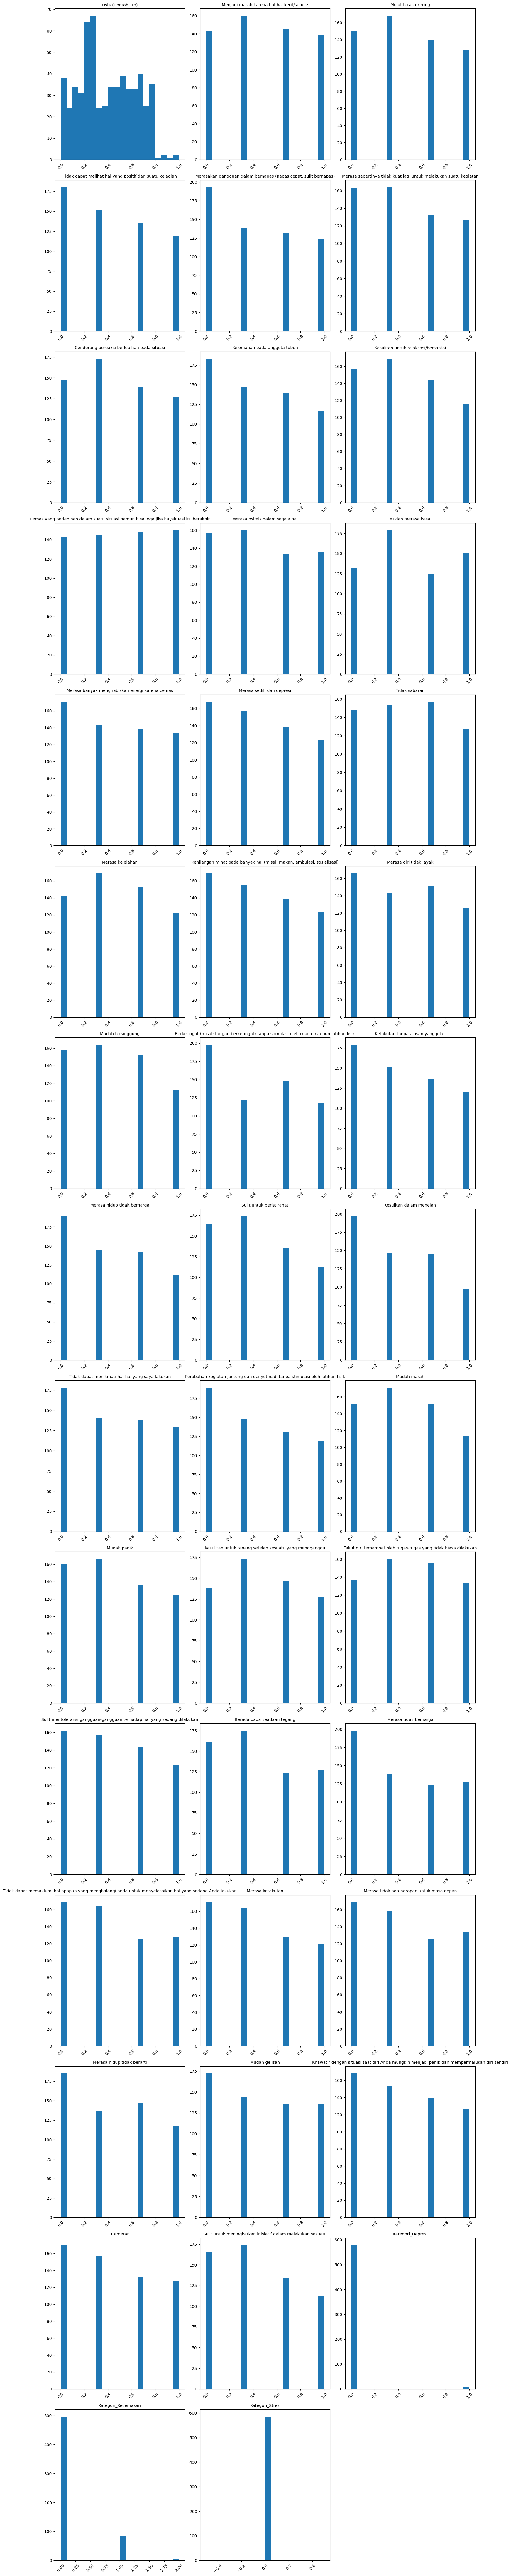


--- Checking Class Distribution in Target ---
Kategori_Depresi
0    579
1      7
Name: count, dtype: int64
Jumlah data setelah filtering: 586
Training data shape: (468, 48)
Testing data shape: (118, 48)
Target training shape: (468, 5)
Target testing shape: (118, 5)


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt

print("\n--- Preprocessing Data ---")

# Cek Missing Values
print("\n--- Checking Missing Values ---")
missing_values = data.isnull().sum()
if missing_values.any():
    print("Missing values found:")
    print(missing_values[missing_values > 0])
else:
    print("No missing values found.")

# Visualisasi Distribusi Fitur
print("\n--- Visualizing Feature Distributions ---")
columns = data.select_dtypes(include=['number']).columns
num_cols = 3

plt.figure(figsize=(15, len(columns) * 2))
for i, col in enumerate(columns, 1):
    plt.subplot((len(columns) // num_cols) + 1, num_cols, i)
    data[col].hist(bins=20, grid=False)
    plt.title(col, fontsize=10)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

X = data.drop(columns=['Kategori_Depresi', 'Kategori_Kecemasan', 'Kategori_Stres', 'Skor_Depresi', 'Skor_Kecemasan', 'Skor_Stres'])
y = data['Kategori_Depresi']

print("\n--- Checking Class Distribution in Target ---")
print(y.value_counts())

allowed_classes = y.value_counts().index.tolist()
data_filtered = data[data['Kategori_Depresi'].isin(allowed_classes)]

print(f"Jumlah data setelah filtering: {data_filtered.shape[0]}")
if data_filtered.shape[0] == 0:
    raise ValueError("Tidak ada data yang tersisa setelah filtering. Periksa kelas yang ada.")

X_filtered = data_filtered.drop(columns=['Kategori_Depresi', 'Kategori_Kecemasan', 'Kategori_Stres', 'Skor_Depresi', 'Skor_Kecemasan', 'Skor_Stres'])
y_filtered = data_filtered['Kategori_Depresi']

label_encoder = LabelEncoder()
for col in X_filtered.select_dtypes(include=['object']).columns:
    X_filtered[col] = label_encoder.fit_transform(X_filtered[col])

X_filtered = X_filtered.apply(pd.to_numeric, errors='coerce')

# Normalisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)

# Melakukan encoding pada target
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_filtered)
y_one_hot = to_categorical(y_encoded, num_classes=5)

# split data train & testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_one_hot, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Target training shape: {y_train.shape}")
print(f"Target testing shape: {y_test.shape}")


In [ ]:
print("Encoded target:", y_encoded[:10])
print("One-hot encoded target shape:", y_one_hot.shape)


Encoded target: [0 0 0 0 0 0 0 0 0 0]
One-hot encoded target shape: (586, 5)


In [ ]:
data.columns = data.columns.str.replace('\n', ' ', regex=False)

print(data.columns)

Index(['Timestamp', 'Email Address', 'Nama', 'Usia (Contoh: 18)',
       'Jenis Kelamin', 'Status Pekerjaan',
       'Saya menyatakan bersedia secara sukarela untuk berpartisipasi pada penelitian ini dengan mengisi kuesioner selama kurang lebih 20-30 menit tanpa paksaan dari pihak manapun. Saya sepenuhnya memahami apa yang telah disampaikan serta apa yang diharapkan dari saya selaku partisipan penelitian. Saya berhak untuk berhenti mengisi kuesioner ini kapan saja tanpa perlu memberikan penjelasan. Saya memberikan izin untuk menggunakan data yang saya berikan hanya untuk kepentingan penelitian ini. Saya telah memahami bahwa informasi yang diperoleh dari penelitian ini sepenuhnya rahasia dan hanya digunakan untuk kepentingan ilmiah',
       'Menjadi marah karena hal-hal kecil/sepele', 'Mulut terasa kering',
       'Tidak dapat melihat hal yang positif dari suatu kejadian',
       'Merasakan gangguan dalam bernapas (napas cepat, sulit bernapas)',
       'Merasa sepertinya tidak kuat lagi

# **BANGUN MODEL**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2

def build_model(input_shape):
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(5, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

input_shape = X_train.shape[1]
model = build_model(input_shape)
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 512)                 │          25,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 201,733 (788.02 KB)

 Trainable params: 199,813 (780.52 KB)

 Non-trainable params: 1,920 (7.50 KB)

# **Train Model**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train.argmax(axis=1)),
    y=y_train.argmax(axis=1)
)
class_weights = dict(enumerate(class_weights))

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

# Train Model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights  # Menambahkan class balancing
)


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.1852 - loss: 9.7471 - val_accuracy: 0.5508 - val_loss: 8.2546 - learning_rate: 0.0010
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1967 - loss: 9.0125 - val_accuracy: 0.1695 - val_loss: 8.3125 - learning_rate: 0.0010
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2370 - loss: 8.0558 - val_accuracy: 0.1186 - val_loss: 8.3306 - learning_rate: 0.0010
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2281 - loss: 8.0740 - val_accuracy: 0.1949 - val_loss: 8.2772 - learning_rate: 0.0010
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2377 - loss: 7.7414 - val_accuracy: 0.2712 - val_loss: 8.2072 - learning_rate: 0.0010
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2579 - loss: 7.7881 - val_accuracy: 0.3814 - val_loss: 8.1092 - learning_rate: 0.0010
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3227 - loss: 7.5603 - 

# **Evaluasi Model**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9739 - loss: 2.9730 
Test Loss: 2.994231939315796
Test Accuracy: 0.9661017060279846
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

--- Classification Report ---
              precision    recall  f1-score   support

      Normal       0.99      0.97      0.98       116
      Ringan       0.25      0.50      0.33         2
      Sedang       0.00      0.00      0.00         0
       Parah       0.00      0.00      0.00         0
Sangat Parah       0.00      0.00      0.00         0

    accuracy                           0.97       118
   macro avg       0.25      0.29      0.26       118
weighted avg       0.98      0.97      0.97       118



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

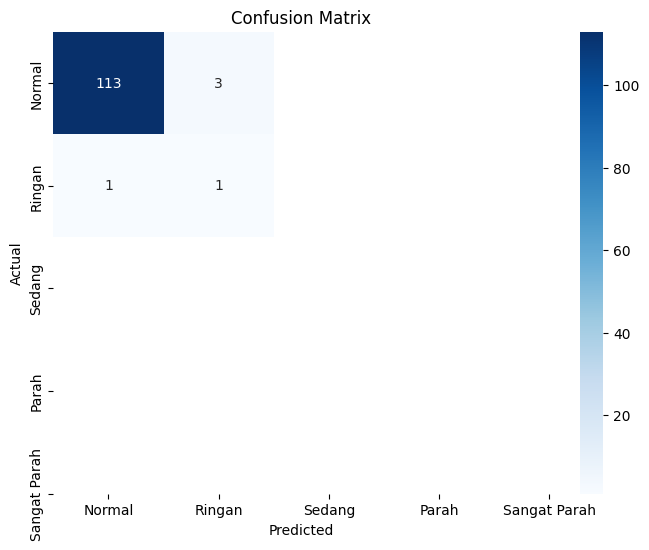

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)

print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'Ringan', 'Sedang', 'Parah', 'Sangat Parah'], labels=[0, 1, 2, 3, 4]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Ringan', 'Sedang', 'Parah', 'Sangat Parah'],
            yticklabels=['Normal', 'Ringan', 'Sedang', 'Parah', 'Sangat Parah'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Simpan dan Deploy Model

In [ ]:
def save_model(model, filename='mindcare_model.h5'):
    """
    Save the trained model to a file.
    """
    model.save(filename)
    print(f"\nModel saved as {filename}")


In [ ]:
!ls -lh

total 120K
-rw-r--r-- 1 root root 114K Nov 30 19:06 dataset.csv
drwxr-xr-x 1 root root 4.0K Nov 25 19:13 sample_data


In [ ]:
# save model .h5
model.save('mindcare_model.h5')
print("Model has been saved as 'mindcare_model.h5'")


Model has been saved as 'mindcare_model.h5'


In [ ]:
from google.colab import files
files.download('mindcare_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>